<a href="https://colab.research.google.com/github/rajathkmanjunath/tsai_assignments/blob/main/compact_mnist_training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compact MNIST Training Pipeline
This notebook trains a lightweight CNN for MNIST classification using advanced augmentations, efficient architecture, and optimized training strategies.

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class CompactCNN(nn.Module):
    def __init__(self):
        super(CompactCNN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model = CompactCNN()
print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Model Parameters: 13808


In [2]:

from torchvision import datasets, transforms

# Define data transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0)),  # Rotate the image
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize with MNIST statistics
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 348kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.69MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:

from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# Optimizer and Scheduler
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20)  # 20 epochs for cyclic learning rate

# Training and validation loops
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss, correct = 0, 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    return train_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return test_loss / len(test_loader.dataset), correct / len(test_loader.dataset)


Epoch 1


100%|██████████| 938/938 [00:34<00:00, 27.16it/s]


Train Loss: 0.3733, Train Accuracy: 0.8960
Test Loss: 0.0605, Test Accuracy: 0.9828
Epoch 2


100%|██████████| 938/938 [00:32<00:00, 28.73it/s]


Train Loss: 0.1023, Train Accuracy: 0.9694
Test Loss: 0.0466, Test Accuracy: 0.9865
Epoch 3


100%|██████████| 938/938 [00:31<00:00, 29.63it/s]


Train Loss: 0.0846, Train Accuracy: 0.9742
Test Loss: 0.0376, Test Accuracy: 0.9884
Epoch 4


100%|██████████| 938/938 [00:32<00:00, 28.84it/s]


Train Loss: 0.0730, Train Accuracy: 0.9781
Test Loss: 0.0351, Test Accuracy: 0.9898
Epoch 5


100%|██████████| 938/938 [00:32<00:00, 28.61it/s]


Train Loss: 0.0659, Train Accuracy: 0.9805
Test Loss: 0.0246, Test Accuracy: 0.9910
Epoch 6


100%|██████████| 938/938 [00:31<00:00, 29.69it/s]


Train Loss: 0.0626, Train Accuracy: 0.9821
Test Loss: 0.0254, Test Accuracy: 0.9921
Epoch 7


100%|██████████| 938/938 [00:32<00:00, 29.18it/s]


Train Loss: 0.0580, Train Accuracy: 0.9822
Test Loss: 0.0231, Test Accuracy: 0.9940
Epoch 8


100%|██████████| 938/938 [00:32<00:00, 29.19it/s]


Train Loss: 0.0554, Train Accuracy: 0.9836
Test Loss: 0.0244, Test Accuracy: 0.9926
Epoch 9


100%|██████████| 938/938 [00:32<00:00, 28.76it/s]


Train Loss: 0.0507, Train Accuracy: 0.9847
Test Loss: 0.0203, Test Accuracy: 0.9934
Epoch 10


100%|██████████| 938/938 [00:31<00:00, 29.72it/s]


Train Loss: 0.0499, Train Accuracy: 0.9847
Test Loss: 0.0194, Test Accuracy: 0.9938
Epoch 11


100%|██████████| 938/938 [00:31<00:00, 29.76it/s]


Train Loss: 0.0463, Train Accuracy: 0.9863
Test Loss: 0.0232, Test Accuracy: 0.9925
Epoch 12


100%|██████████| 938/938 [00:32<00:00, 28.43it/s]


Train Loss: 0.0459, Train Accuracy: 0.9864
Test Loss: 0.0201, Test Accuracy: 0.9934
Epoch 13


100%|██████████| 938/938 [00:32<00:00, 29.22it/s]


Train Loss: 0.0442, Train Accuracy: 0.9863
Test Loss: 0.0204, Test Accuracy: 0.9933
Epoch 14


100%|██████████| 938/938 [00:31<00:00, 29.32it/s]


Train Loss: 0.0427, Train Accuracy: 0.9872
Test Loss: 0.0204, Test Accuracy: 0.9935
Epoch 15


100%|██████████| 938/938 [00:31<00:00, 29.72it/s]


Train Loss: 0.0412, Train Accuracy: 0.9876
Test Loss: 0.0191, Test Accuracy: 0.9942
Epoch 16


100%|██████████| 938/938 [00:32<00:00, 29.19it/s]


Train Loss: 0.0397, Train Accuracy: 0.9884
Test Loss: 0.0181, Test Accuracy: 0.9939
Epoch 17


100%|██████████| 938/938 [00:32<00:00, 29.07it/s]


Train Loss: 0.0382, Train Accuracy: 0.9883
Test Loss: 0.0177, Test Accuracy: 0.9947
Epoch 18


100%|██████████| 938/938 [00:31<00:00, 29.90it/s]


Train Loss: 0.0381, Train Accuracy: 0.9884
Test Loss: 0.0184, Test Accuracy: 0.9939
Epoch 19


100%|██████████| 938/938 [00:32<00:00, 28.75it/s]


Train Loss: 0.0379, Train Accuracy: 0.9891
Test Loss: 0.0179, Test Accuracy: 0.9941
Epoch 20


100%|██████████| 938/938 [00:32<00:00, 29.10it/s]


Train Loss: 0.0388, Train Accuracy: 0.9881
Test Loss: 0.0180, Test Accuracy: 0.9944


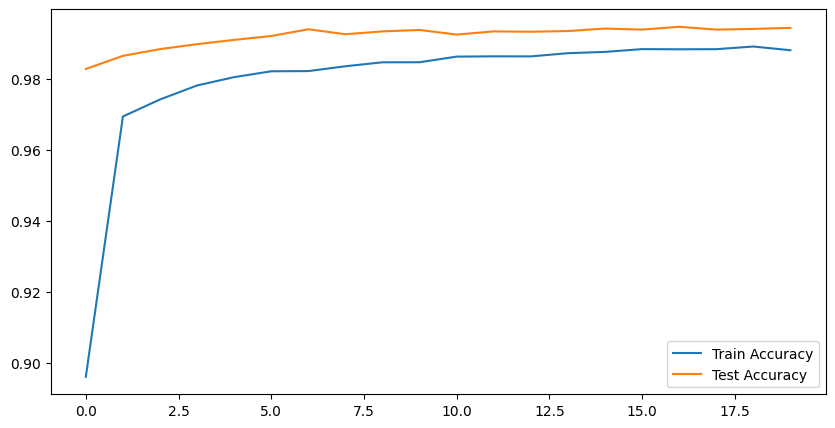

In [4]:

# Training script
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(1, 21):  # Train for 20 epochs
    print(f"Epoch {epoch}")
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)

    scheduler.step()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.legend()
plt.show()
